<h1 style="font-size:25px;">Proyecto Retención de clientes en  Modelfitness </h1> 

<h1 style="font-size:20px;">Descripcion general del proyecto</h1> 
Análisis predictivo de cancelación de clientes en Model Fitness


Objetivo:
El objetivo de este proyecto es desarrollar una estrategia basada en datos para identificar y reducir la tasa de cancelación de clientes en la cadena de gimnasios Model Fitness, mediante el análisis del comportamiento de los usuarios, la segmentación de clientes y la implementación de modelos de predicción.


La cancelación de membresías (churn) es uno de los desafíos más críticos para los gimnasios. Muchas veces, los clientes dejan de asistir sin notificar formalmente su baja, lo que dificulta la planificación operativa y comercial. Para abordar este problema, Model Fitness digitalizó sus datos de clientes, incluyendo variables demográficas, de contrato, asistencia, consumo de servicios y promoción.




In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans

<h1 style="font-size:20px;">Paso 1 Descargar los datos</h1> 

In [2]:
df = pd.read_csv('/datasets/gym_churn_us.csv')

In [3]:
print(df)

      gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0          1              1        1              1      0                6   
1          0              1        0              0      1               12   
2          0              1        1              0      1                1   
3          0              1        1              1      1               12   
4          1              1        1              1      1                1   
...      ...            ...      ...            ...    ...              ...   
3995       1              1        1              0      1               12   
3996       0              1        0              0      1                1   
3997       1              1        1              1      1               12   
3998       0              1        1              1      1                6   
3999       1              0        1              0      0               12   

      Group_visits  Age  Avg_additional_charges_tot

<h1 style="font-size:20px;">Paso 2  Análisis exploratorio de datos (EDA)</h1> 

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [5]:
print(df.isnull().sum())

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64


In [6]:
print(df.duplicated().sum())

0


In [7]:
print(df.describe())

            gender  Near_Location      Partner  Promo_friends        Phone  \
count  4000.000000    4000.000000  4000.000000    4000.000000  4000.000000   
mean      0.510250       0.845250     0.486750       0.308500     0.903500   
std       0.499957       0.361711     0.499887       0.461932     0.295313   
min       0.000000       0.000000     0.000000       0.000000     0.000000   
25%       0.000000       1.000000     0.000000       0.000000     1.000000   
50%       1.000000       1.000000     0.000000       0.000000     1.000000   
75%       1.000000       1.000000     1.000000       1.000000     1.000000   
max       1.000000       1.000000     1.000000       1.000000     1.000000   

       Contract_period  Group_visits          Age  \
count      4000.000000   4000.000000  4000.000000   
mean          4.681250      0.412250    29.184250   
std           4.549706      0.492301     3.258367   
min           1.000000      0.000000    18.000000   
25%           1.000000      0.00

In [8]:
print(df['Churn'].value_counts())

0    2939
1    1061
Name: Churn, dtype: int64


In [9]:
grouped_means = df.groupby('Churn').mean(numeric_only=True)
print("Valores medios por grupo (0 = se quedó, 1 = canceló):")
print(grouped_means.transpose())  

Valores medios por grupo (0 = se quedó, 1 = canceló):
Churn                                       0           1
gender                               0.510037    0.510839
Near_Location                        0.873086    0.768143
Partner                              0.534195    0.355325
Promo_friends                        0.353522    0.183789
Phone                                0.903709    0.902922
Contract_period                      5.747193    1.728558
Group_visits                         0.464103    0.268615
Age                                 29.976523   26.989632
Avg_additional_charges_total       158.445715  115.082899
Month_to_end_contract                5.283089    1.662582
Lifetime                             4.711807    0.990575
Avg_class_frequency_total            2.024876    1.474995
Avg_class_frequency_current_month    2.027882    1.044546


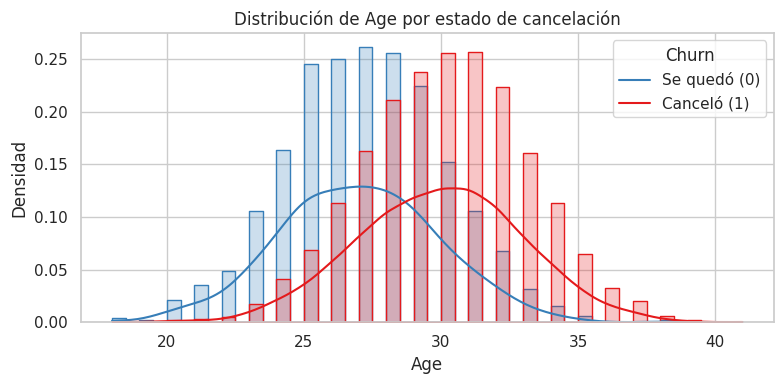

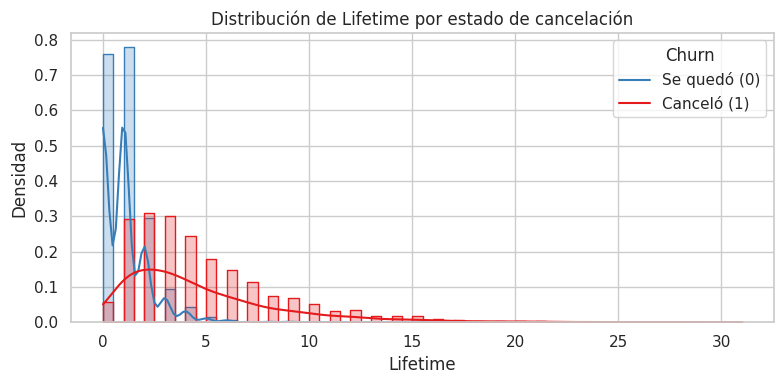

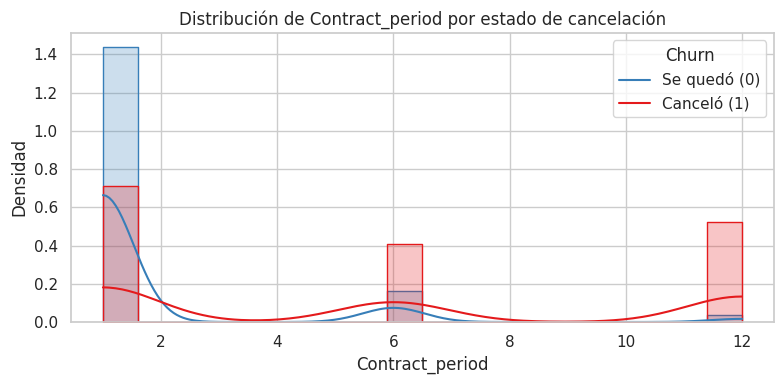

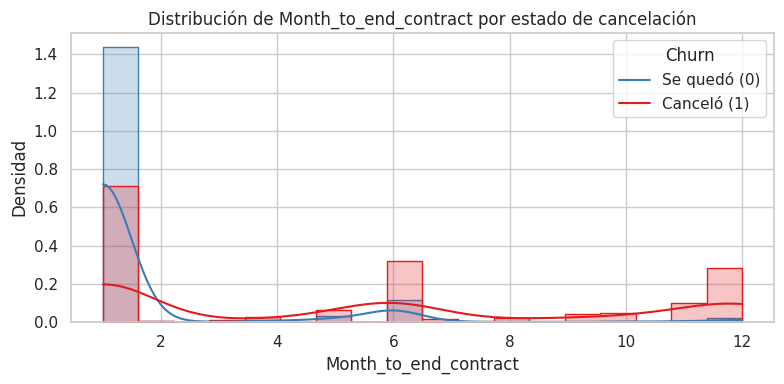

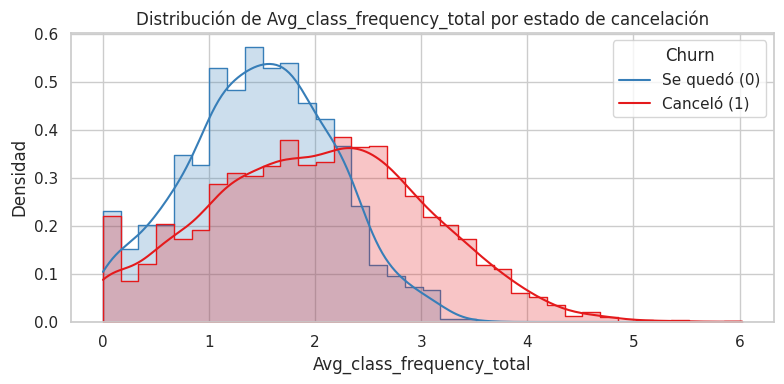

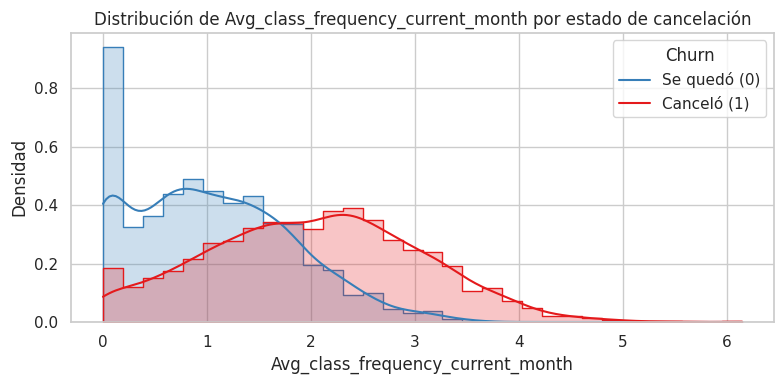

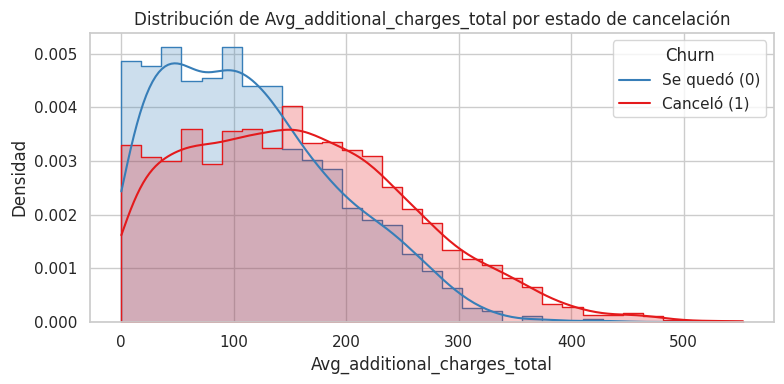

In [10]:
sns.set(style="whitegrid")


features = [
    'Age', 'Lifetime', 'Contract_period', 'Month_to_end_contract',
    'Avg_class_frequency_total', 'Avg_class_frequency_current_month',
    'Avg_additional_charges_total'
]


for feature in features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=feature, hue='Churn', kde=True, palette='Set1', element="step", stat="density", common_norm=False)
    plt.title(f'Distribución de {feature} por estado de cancelación')
    plt.xlabel(feature)
    plt.ylabel('Densidad')
    plt.legend(title='Churn', labels=['Se quedó (0)', 'Canceló (1)'])
    plt.tight_layout()
    plt.show()

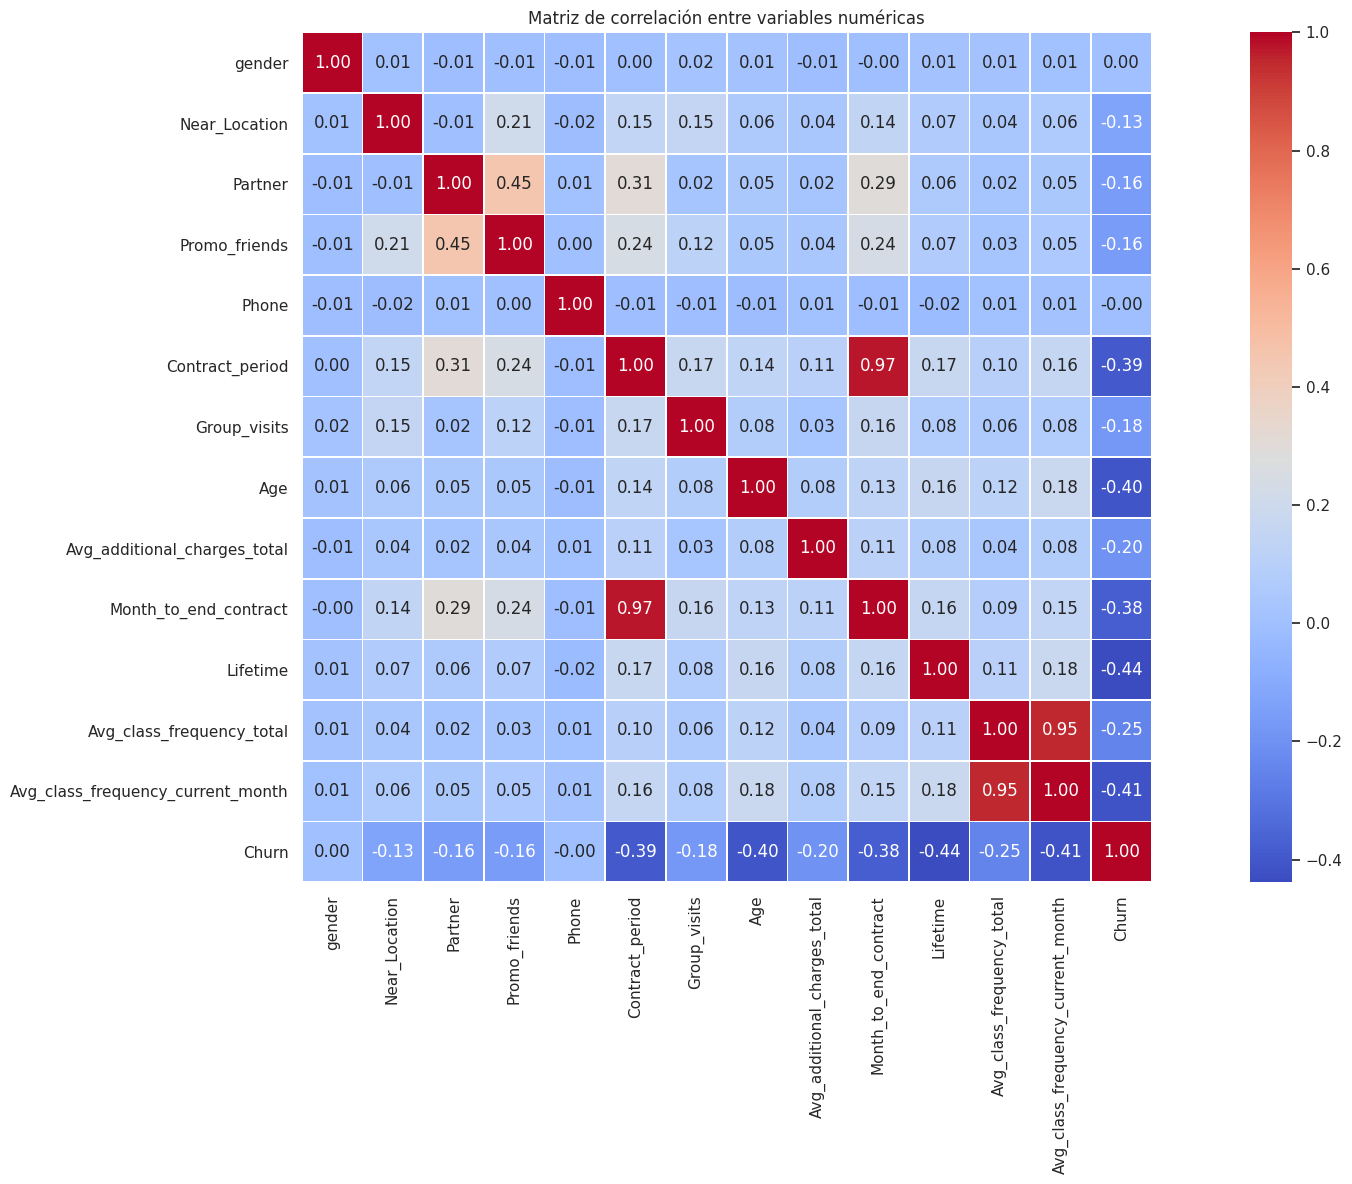

In [11]:
correlation_matrix = df.select_dtypes(include='number').corr()


plt.figure(figsize=(20,12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Matriz de correlación entre variables numéricas')
plt.tight_layout()
plt.show()

Observaciones:

- No se encontraron valores ausentes.

- Todos los tipos de datos pertenecen al tipo correcto en enteros y flotantes.

- Analizando los valores ausentes y la desviacion estandar se puede comenzar a identificar lo siguiente:

  *Quienes viven cerca del gimnasio tienden a quedarse más

  *Tener una empresa asociada juega un papel importante de retención.

  *Inscribirse por recomendación de amigos parece disminuir la probabilidad de cancelar.

  *Los que firmaron contratos más largos tienen menor churn.

  *Participar en clases grupales está fuertemente asociado con la permanencia.

  *Los clientes más jóvenes tienden a cancelar más.

  *Los que gastan más en servicios adicionales (masajes, cafetería, etc.) tienden a quedarse.

  *Quienes están más cerca de finalizar su contrato cancelan más.

  *Churn está fuertemente relacionado con poca antigüedad en el gimnasio.

  *Menor frecuencia histórica de visitas se asocia con cancelación.


Observaciones preeliminares:


También se puede comenzar a notar que algunos de los factores que pueden fortalecer y en los que hay que enfocarse para la retencion de clientes son:


*Buscar formas hacer contratos largos

*Alta frecuencia de visitas (histórica y reciente)

*Participación en clases grupales

*Vivir cerca del gimnasio

*Ser parte de una empresa asociada

*Llegar recomendado por un amigo (Promo_friends)


Por otro lado los factores con churn y que influyen en que se pierdan clientes son:

*Edad más baja

*Clientes nuevos (Lifetime bajo)

*Menor gasto en servicios adicionales

*Contratos a corto plazo

*Ausencias recientes (menos visitas este mes)


Las variables que tienen poco impacto y no influyen mucho son:

*El género 

*La proporción de personas que entregaron el número de teléfono.



<h1 style="font-size:20px;">Paso 3.- Construir un modelo para predecir la cancelacion de usuarios </h1> 

1.- Dividir los datos en conjuntos de entrenamiento y validación

In [12]:
y = df['Churn']
X = df.drop('Churn', axis=1)


X = pd.get_dummies(X, drop_first=True)


X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


print("Tamaño del set de entrenamiento:", X_train.shape)
print("Tamaño del set de validación:", X_valid.shape)

Tamaño del set de entrenamiento: (3200, 13)
Tamaño del set de validación: (800, 13)


2.- Entrenar el modelo

In [13]:
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)


rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

3.- Evaluar la exactitud, precisión y recall para ambos modelos

In [14]:
y_pred_log = log_model.predict(X_valid)
y_pred_rf = rf_model.predict(X_valid)


acc_log = accuracy_score(y_valid, y_pred_log)
prec_log = precision_score(y_valid, y_pred_log)
rec_log = recall_score(y_valid, y_pred_log)


acc_rf = accuracy_score(y_valid, y_pred_rf)
prec_rf = precision_score(y_valid, y_pred_rf)
rec_rf = recall_score(y_valid, y_pred_rf)


print("=== Regresión Logística ===")
print(f"Accuracy:  {acc_log:.3f}")
print(f"Precision: {prec_log:.3f}")
print(f"Recall:    {rec_log:.3f}")

print("\n=== Bosque Aleatorio ===")
print(f"Accuracy:  {acc_rf:.3f}")
print(f"Precision: {prec_rf:.3f}")
print(f"Recall:    {rec_rf:.3f}")

=== Regresión Logística ===
Accuracy:  0.924
Precision: 0.876
Recall:    0.830

=== Bosque Aleatorio ===
Accuracy:  0.927
Precision: 0.885
Recall:    0.835


Observaciones:


Con la informacion obtenida anteriormente se puede notar que el modelo de bosque aleatorio es superior en las tres métricas, aunque las diferencias sean pequeñas. Además, el Random Forest tiene la ventaja de capturar relaciones no lineales y complejas entre variables, lo cual es útil en datos de comportamiento de usuarios como en este caso. Y por ultimo tambien al detectar a tiempo a los clientes que podrían cancelar (es decir, maximizar el recall), el bosque aleatorio es  mejor opción.



<h1 style="font-size:20px;">Paso 4.- Crear clústeres de usuarios/as</h1>

1.- Estandarizar los datos

In [15]:
df_features = df.drop(columns=['Churn'])


scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_features)

Paso 2.- Crear una matriz de distancias basada en la matriz de características estandarizada y trazar un dendrograma

In [16]:
linked = sch.linkage(scaled_features, method='ward')

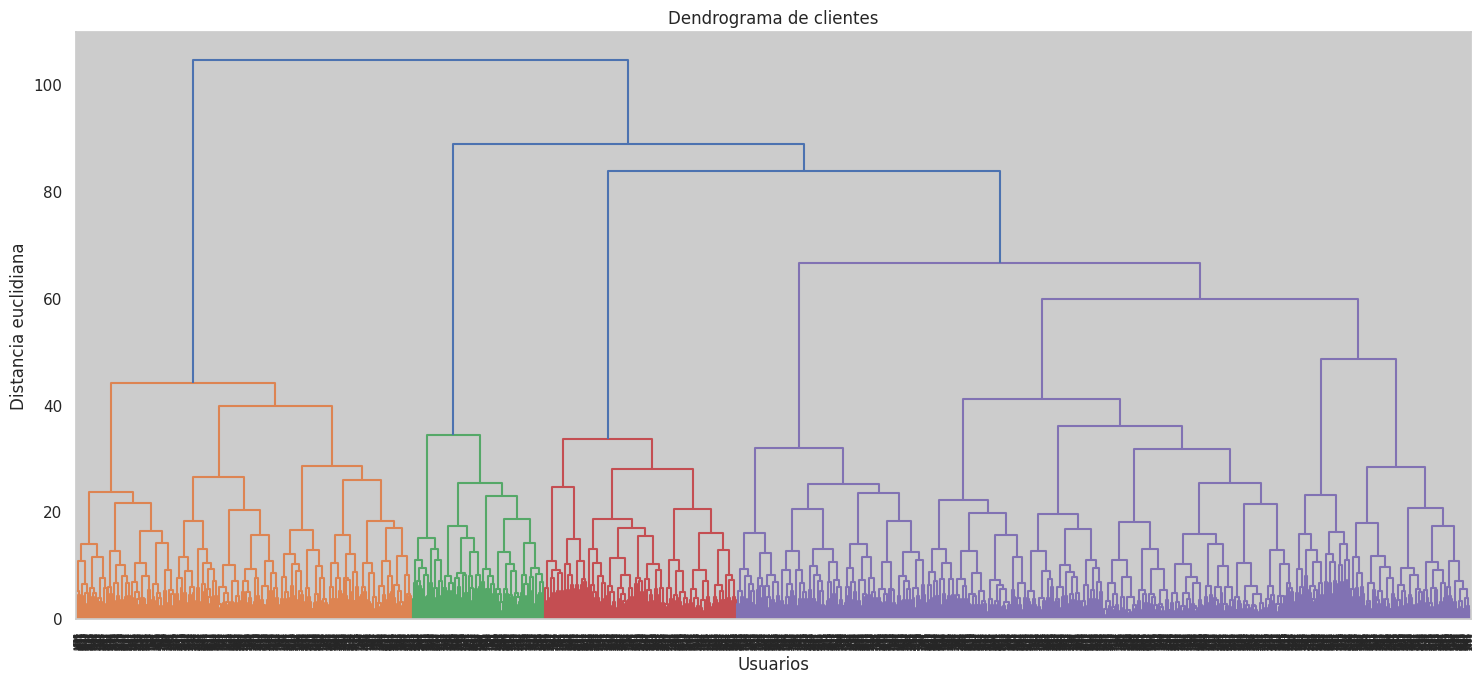

In [17]:
plt.figure(figsize=(15, 7))
dendrogram = sch.dendrogram(linked)
plt.title('Dendrograma de clientes')
plt.xlabel('Usuarios')
plt.ylabel('Distancia euclidiana')
plt.tight_layout()
plt.show()

3.- Entrenar el modelo de clustering con el algortimo K-means

In [18]:
kmeans = KMeans(n_clusters=5, random_state=42)


kmeans.fit(scaled_features)


cluster_labels = kmeans.labels_


df['Cluster'] = cluster_labels

4.- Observar los valores medios de característica para los clústeres.

In [19]:
cluster_means = df.groupby('Cluster').mean(numeric_only=True)
print(cluster_means)

           gender  Near_Location   Partner  Promo_friends  Phone  \
Cluster                                                            
0        0.502370       0.949447  0.829384       0.998420    1.0   
1        0.554556       0.849269  0.263217       0.052868    1.0   
2        0.499422       0.937572  0.737572       0.478613    1.0   
3        0.485738       0.718011  0.299919       0.018745    1.0   
4        0.523316       0.862694  0.471503       0.305699    0.0   

         Contract_period  Group_visits        Age  \
Cluster                                             
0               3.097946      0.448657  29.104265   
1               2.606299      0.436445  30.008999   
2              11.854335      0.546821  29.905202   
3               1.914425      0.276284  28.083945   
4               4.777202      0.427461  29.297927   

         Avg_additional_charges_total  Month_to_end_contract  Lifetime  \
Cluster                                                                  
0  

Obseraciones

¿Hay algo que llame la atencion?

Si, ya que  los cluster 2 y 1 son los más valiosos: altas visitas, gasto y retención. Fidelízalos. El Clúster 3 es crítico: alto churn, baja interacción. Enfoca campañas preventivas aquí y los clústeres 0 y 4 están en la “zona gris”. Pueden mejorar con incentivos y seguimiento.

En general se puede observar que:

En el clúster 2 los Usuarios más leales (Churn = 2%) ya que hay altísima retención, los contratos muy largos (11.85 meses), tienen, buena frecuencia de visita y gasto y alta proporción con descuento corporativo (Partner = 74%) y viven cerca, bastante uso de promociones y visitas grupales. En otras palabras son clientes fieles, leales, comprometido, con contrato largo.

Mientras que el cluster 0 es el que tiene un riesgo  moderado-bajo (Churn = 25%) ya que Este grupo entró por promoción, pero se está yendo en 1 de cada 4 casos. 

5.- Trazar las distribuciones de caracteristicas para los clústeres.

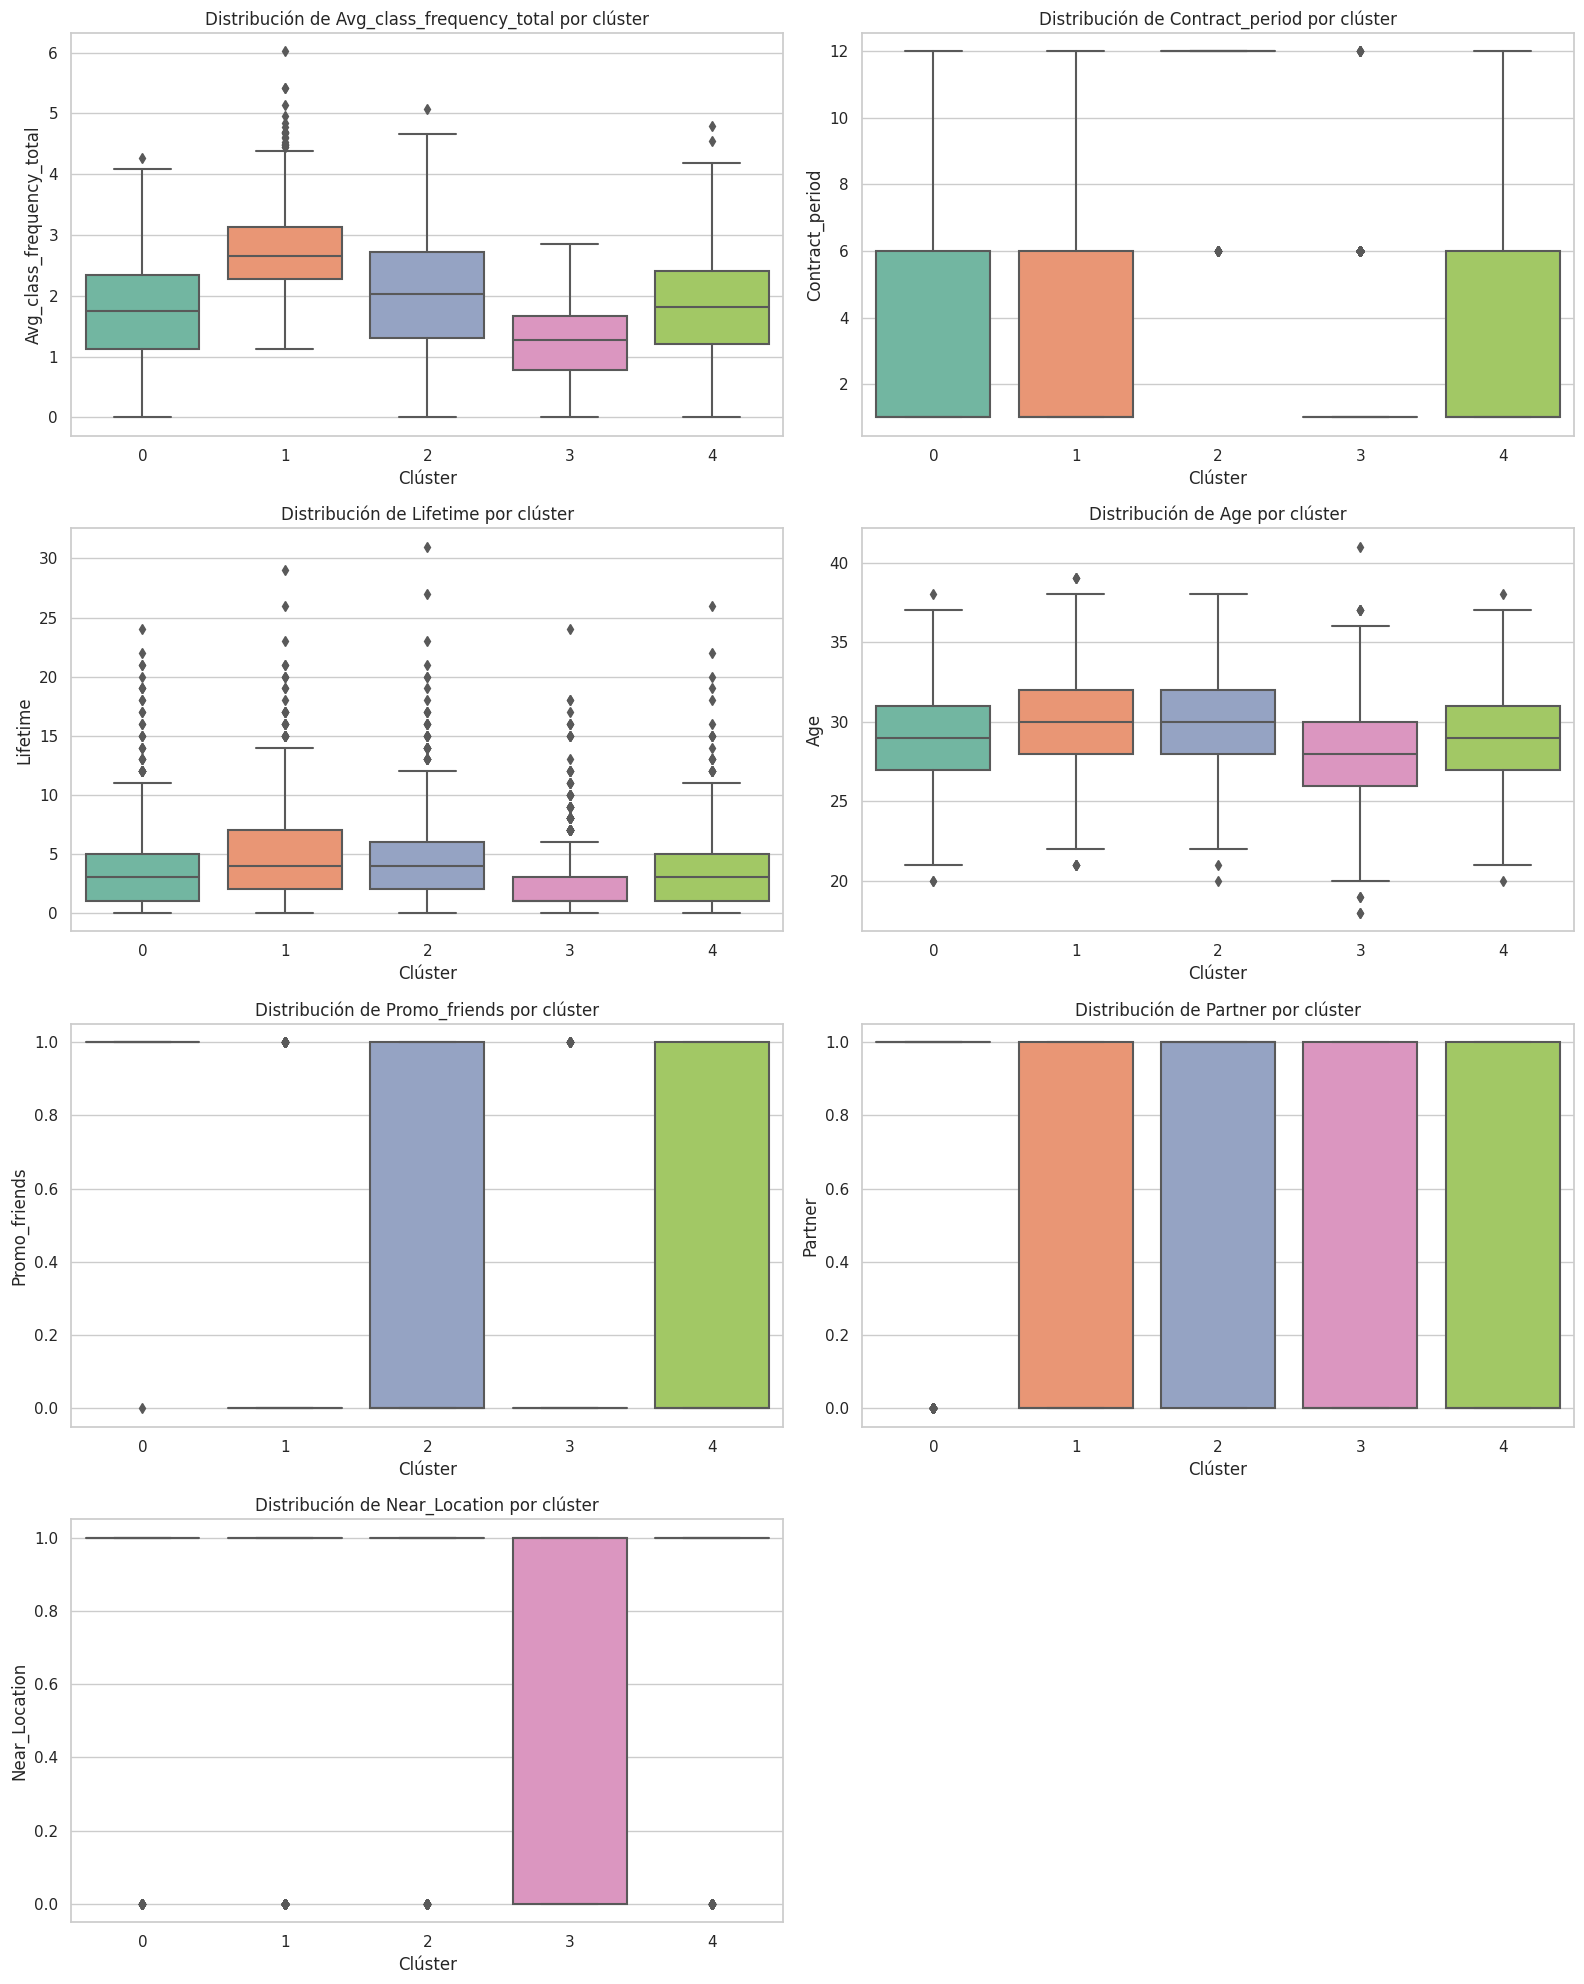

In [20]:
df_clustered = df.copy()
df_clustered['cluster'] = kmeans.labels_


features = [
    'Avg_class_frequency_total',
    'Contract_period',
    'Lifetime',
    'Age',
    'Promo_friends',
    'Partner',
    'Near_Location'
]


plt.figure(figsize=(16, 20))


for i, feature in enumerate(features):
    plt.subplot(4, 2, i+1)
    sns.boxplot(x='cluster', y=feature, data=df_clustered, palette='Set2')
    plt.title(f'Distribución de {feature} por clúster')
    plt.xlabel('Clúster')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

6.- Carcular la tasa de cancelación para cada clúster

In [21]:
cancelation_rates = df_clustered.groupby('cluster')['Churn'].mean().sort_values(ascending=False)

print("Tasa de cancelación por clúster:")
print(cancelation_rates)

Tasa de cancelación por clúster:
cluster
3    0.572942
4    0.266839
0    0.246445
1    0.089989
2    0.021965
Name: Churn, dtype: float64


Observaciones:

Despues de analizar la informacion anterior se puede notar que el clúster 3 (tasa 57%)  es el grupo más propenso a cancelar ya que tiene contratos cortos, frecuencia baja de asistencia, poca participación en actividades grupales, Poca antigüedad (o Lifetime bajo) , baja participación en promociones o descuentos y menor proximidad al gimnasio.


Por otra parte el clúster 1 (9%) y Clúster 0 (24%) tienen niveles de cancelación intermedios-bajos, debido a que el clúster 1 muestra alta frecuencia de uso, aunque menos compromiso con las promociones y el clúster 0 tiene altísima participación en promociones, pero su cancelación es más alta, quizá por contratos más cortos. De igual forma, el clúster 4 (27%): Similar al 0 en características, pero con menos promociones y visitas que el 2 o 1.

Mientras que el cluster 2  (tasa del 2%) es un grupo más leal y más propenso a quedarse ya que tiene contratos anuales, alta frecuencia de asistencia, alta antigüedad como cliente, altos gastos adicionales y participación en actividades y promociones. En otras palabras, este es un perfil ideal para fidelizar y usar como referencia para retención


<h1 style="font-size:20px;">Paso 5 Conclusiones y hacer recomendaciones</h1> 

Despues de haber analizado todas las graficas e informacion anterior se puede concluir y hacer las siguientes recomendaciones:


Conclusiones:

1.- Los Factores clave que predicen la cancelación son:
-Frecuencia baja de asistencia (empiezan a faltar)
-Contratos de corto plazo (1-3 meses). 
-No participación en actividades grupales o promociones.
-Baja antigüedad como cliente.
-Menor gasto en servicios adicionales.

2.-Los modelos predictivos son eficaces:

-El modelo de bosque aleatorio tuvo mejor desempeño que la regresión logística, con mayor precisión y recall.
-Puede  predecir clientes en riesgo con buena fiabilidad.

3.- Hay segmentación clara en 5 clústeres por ejemplo:

Clúster 3: clientes en alto riesgo de cancelación (57% de tasa).
Clúster 2: clientes muy leales (2% de tasa), con contratos largos y alta frecuencia.
Clústeres 0 y 4: segmentos intermedios, necesitan seguimiento.
Clúster 1: buen nivel de fidelidad y participación, aunque bajo uso de promociones.


Por lo anterior, se pueden sacar las siguientes recomendaciones:

Recomendaciones:

1.-Crear un sistema de alertas tempranas e Implementar modelo predictivo para detectar usuarios con alta probabilidad de cancelación (similar al clúster 3). Puede ser enviando correos personalizados o mensajes de WhatsApp ofreciendo promociones si no han asistido en 7–10 días o bien invitar a los clientes a eventos especiales o sesiones grupales. (principalmente a personas jovenes, personas que vivan lejos del gimnacio, clientes con contrato a corto plazo y personas que hayan entrado por promoción)

2.-Fortalecer programas de fidelización y fomentar la participación en promociones como “trae a un amigo” y clases grupales ya se ofreciendo descuentos si asisten con alguien nuevo o bien dando beneficios por asistir a 3 clases semanales.


3.- Diseñar contratos personalizados y cambiar a  usuarios de contratos cortos a más largos con incentivos, sobre todo si muestran señales de lealtad (alta frecuencia o gasto). Lo cual se puede lograr ofreciendo un mes gratis al pasar de contrato mensual a trimestral o anual o tambien por bonos por renovación anticipada.


4.- Cuidar y potenciar a los clientes leales con programas VIP con recompensas por referidos y aplicando encuestas para entender su experiencia y replicarla con los clientes que se identificó que no son leales.







